# LSGAN for MNIST

In [1]:
import numpy as np
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
def define_discriminator(in_shape=(28,28,1)):
	init = RandomNormal(stddev=0.02)
	model = Sequential()
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dense(1, activation='linear', kernel_initializer=init))
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0

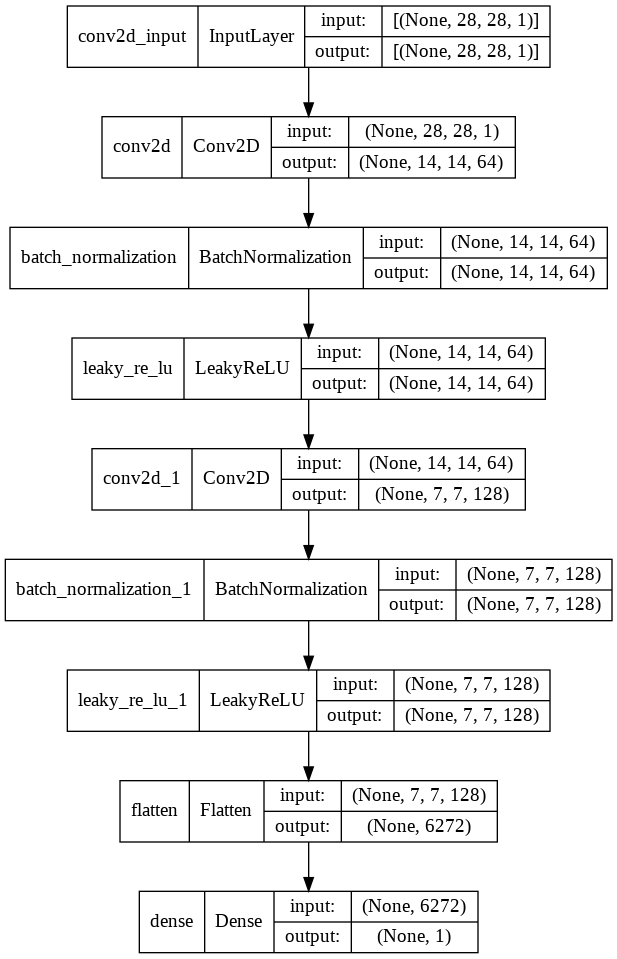

In [3]:
discriminator_model = define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file = 'discriminator_model.png', show_shapes = True, show_layer_names = True)

In [4]:
def define_generator(latent_dim):
	init = RandomNormal(stddev=0.02)
	model = Sequential()
	n_nodes = 256 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Reshape((7, 7, 256)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Conv2D(1, (7,7), padding='same', kernel_initializer=init))
	model.add(Activation('tanh'))
	return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_2 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      524416    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 128)     

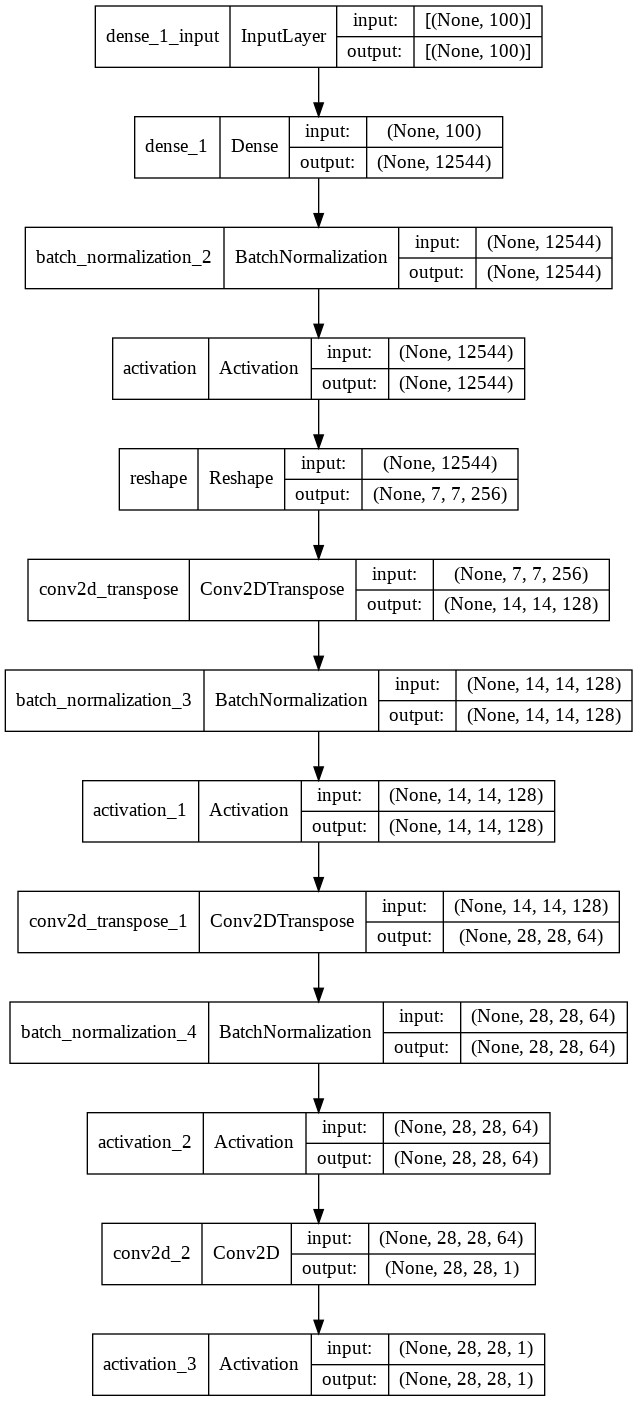

In [5]:
latent_dim = 100
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

In [6]:
def define_gan(generator, discriminator):
	for layer in discriminator.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1976577   
                                                                 
 sequential (Sequential)     (None, 1)                 139329    
                                                                 
Total params: 2,115,906
Trainable params: 1,951,489
Non-trainable params: 164,417
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


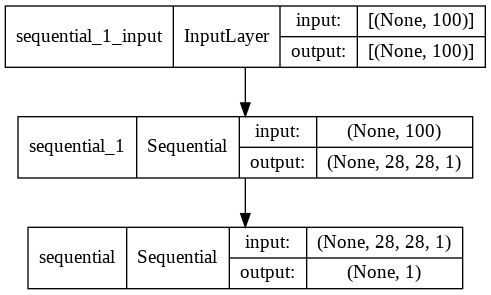

In [7]:
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

In [8]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	return X

In [9]:
def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

In [10]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [11]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y

In [12]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	X = (X + 1) / 2.0
	for i in range(10 * 10):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.show()
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('Saved %s and %s' % (filename1, filename2))

In [13]:
def plot_history(d1_hist, d2_hist, g_hist):
	plt.plot(d1_hist, label='dloss1')
	plt.plot(d2_hist, label='dloss2')
	plt.plot(g_hist, label='gloss')
	plt.legend()
	filename = 'plot_line_plot_loss.png'
	plt.savefig(filename)
	plt.close()
	print('=> Saved %s' % (filename))

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=64):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	d1_hist, d2_hist, g_hist = list(), list(), list()
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	for i in range(n_steps):
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = np.ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		if (i+1) in (1, n_steps) or (i+1) % 100 == 0:
			print('> Step %d: d_loss1=%.3f, d_loss2=%.3f, g_loss=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
		d1_hist.append(d_loss1)
		d2_hist.append(d_loss2)
		g_hist.append(g_loss)
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, latent_dim)
	plot_history(d1_hist, d2_hist, g_hist)

In [15]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
dataset = load_real_samples()
print(dataset.shape)

11501568/11490434 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


n_epochs=20, n_batch=64, 1/2=32, b/e=937, steps=18740
> Step 1: d_loss1=1.349, d_loss2=0.467, g_loss=1.429
> Step 100: d_loss1=0.134, d_loss2=0.099, g_loss=0.132
> Step 200: d_loss1=0.106, d_loss2=0.016, g_loss=0.351
> Step 300: d_loss1=0.051, d_loss2=0.012, g_loss=0.298
> Step 400: d_loss1=0.148, d_loss2=1.545, g_loss=0.781
> Step 500: d_loss1=0.046, d_loss2=0.102, g_loss=0.048
> Step 600: d_loss1=0.039, d_loss2=0.962, g_loss=1.152
> Step 700: d_loss1=0.031, d_loss2=0.226, g_loss=0.458
> Step 800: d_loss1=0.050, d_loss2=0.104, g_loss=0.936
> Step 900: d_loss1=0.079, d_loss2=0.113, g_loss=0.226


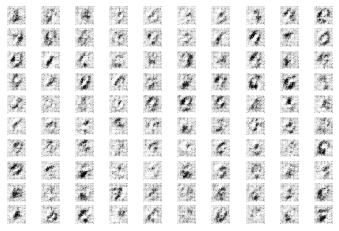

Saved generated_plot_000937.png and model_000937.h5
> Step 1000: d_loss1=0.020, d_loss2=0.051, g_loss=0.067
> Step 1100: d_loss1=0.257, d_loss2=0.137, g_loss=0.498
> Step 1200: d_loss1=0.306, d_loss2=0.201, g_loss=0.340
> Step 1300: d_loss1=0.204, d_loss2=0.254, g_loss=0.724
> Step 1400: d_loss1=0.238, d_loss2=0.165, g_loss=0.627
> Step 1500: d_loss1=0.187, d_loss2=0.425, g_loss=0.586
> Step 1600: d_loss1=0.092, d_loss2=0.073, g_loss=0.945
> Step 1700: d_loss1=0.073, d_loss2=0.177, g_loss=0.928
> Step 1800: d_loss1=0.141, d_loss2=0.249, g_loss=0.781


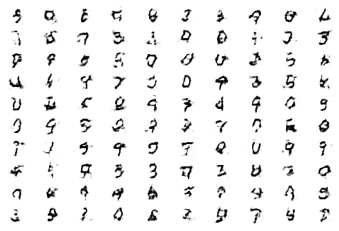

Saved generated_plot_001874.png and model_001874.h5
> Step 1900: d_loss1=0.126, d_loss2=0.255, g_loss=1.071
> Step 2000: d_loss1=0.184, d_loss2=0.161, g_loss=0.731
> Step 2100: d_loss1=0.346, d_loss2=0.192, g_loss=0.571
> Step 2200: d_loss1=0.169, d_loss2=0.263, g_loss=0.611
> Step 2300: d_loss1=0.327, d_loss2=0.223, g_loss=0.545
> Step 2400: d_loss1=0.216, d_loss2=0.306, g_loss=0.530
> Step 2500: d_loss1=0.364, d_loss2=0.290, g_loss=0.585
> Step 2600: d_loss1=0.223, d_loss2=0.210, g_loss=0.624
> Step 2700: d_loss1=0.128, d_loss2=0.163, g_loss=0.677
> Step 2800: d_loss1=0.138, d_loss2=0.041, g_loss=0.321


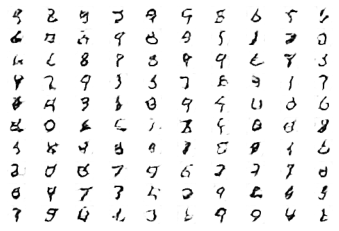

Saved generated_plot_002811.png and model_002811.h5
> Step 2900: d_loss1=0.297, d_loss2=0.261, g_loss=0.533
> Step 3000: d_loss1=0.152, d_loss2=0.242, g_loss=0.566
> Step 3100: d_loss1=0.243, d_loss2=0.199, g_loss=0.605
> Step 3200: d_loss1=0.194, d_loss2=0.163, g_loss=0.577
> Step 3300: d_loss1=0.217, d_loss2=0.297, g_loss=0.484
> Step 3400: d_loss1=0.119, d_loss2=0.206, g_loss=0.639
> Step 3500: d_loss1=0.191, d_loss2=0.182, g_loss=0.684
> Step 3600: d_loss1=0.177, d_loss2=0.114, g_loss=0.531
> Step 3700: d_loss1=0.226, d_loss2=0.218, g_loss=0.443


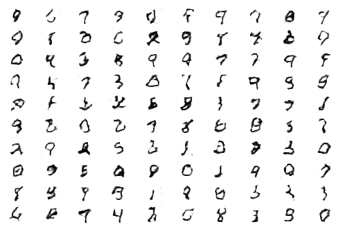

Saved generated_plot_003748.png and model_003748.h5
> Step 3800: d_loss1=0.262, d_loss2=0.326, g_loss=0.498
> Step 3900: d_loss1=0.205, d_loss2=0.195, g_loss=0.585
> Step 4000: d_loss1=0.239, d_loss2=0.242, g_loss=0.453
> Step 4100: d_loss1=0.316, d_loss2=0.204, g_loss=0.597
> Step 4200: d_loss1=0.499, d_loss2=0.320, g_loss=0.393
> Step 4300: d_loss1=0.475, d_loss2=0.335, g_loss=0.403
> Step 4400: d_loss1=0.244, d_loss2=0.253, g_loss=0.505
> Step 4500: d_loss1=0.274, d_loss2=0.261, g_loss=0.477
> Step 4600: d_loss1=0.178, d_loss2=0.191, g_loss=0.380


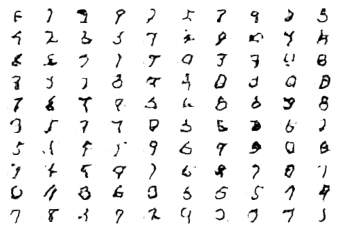

Saved generated_plot_004685.png and model_004685.h5
> Step 4700: d_loss1=0.163, d_loss2=0.202, g_loss=0.443
> Step 4800: d_loss1=0.144, d_loss2=0.282, g_loss=0.425
> Step 4900: d_loss1=0.162, d_loss2=0.215, g_loss=0.444
> Step 5000: d_loss1=0.321, d_loss2=0.300, g_loss=0.370
> Step 5100: d_loss1=0.179, d_loss2=0.265, g_loss=0.344
> Step 5200: d_loss1=0.284, d_loss2=0.263, g_loss=0.391
> Step 5300: d_loss1=0.139, d_loss2=0.263, g_loss=0.403
> Step 5400: d_loss1=0.288, d_loss2=0.264, g_loss=0.399
> Step 5500: d_loss1=0.277, d_loss2=0.242, g_loss=0.399
> Step 5600: d_loss1=0.282, d_loss2=0.310, g_loss=0.356


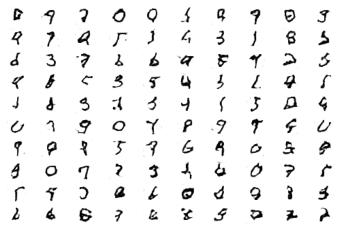

Saved generated_plot_005622.png and model_005622.h5
> Step 5700: d_loss1=0.247, d_loss2=0.208, g_loss=0.367
> Step 5800: d_loss1=0.199, d_loss2=0.175, g_loss=0.436
> Step 5900: d_loss1=0.211, d_loss2=0.266, g_loss=0.491
> Step 6000: d_loss1=0.276, d_loss2=0.288, g_loss=0.316
> Step 6100: d_loss1=0.218, d_loss2=0.303, g_loss=0.437
> Step 6200: d_loss1=0.229, d_loss2=0.265, g_loss=0.453
> Step 6300: d_loss1=0.324, d_loss2=0.277, g_loss=0.346
> Step 6400: d_loss1=0.253, d_loss2=0.251, g_loss=0.404
> Step 6500: d_loss1=0.288, d_loss2=0.285, g_loss=0.348


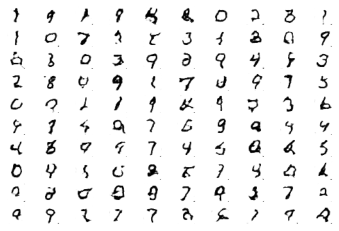

Saved generated_plot_006559.png and model_006559.h5
> Step 6600: d_loss1=0.393, d_loss2=0.316, g_loss=0.470
> Step 6700: d_loss1=0.288, d_loss2=0.295, g_loss=0.312
> Step 6800: d_loss1=0.362, d_loss2=0.324, g_loss=0.272
> Step 6900: d_loss1=0.241, d_loss2=0.356, g_loss=0.333
> Step 7000: d_loss1=0.298, d_loss2=0.293, g_loss=0.364
> Step 7100: d_loss1=0.296, d_loss2=0.288, g_loss=0.322
> Step 7200: d_loss1=0.340, d_loss2=0.294, g_loss=0.305
> Step 7300: d_loss1=0.255, d_loss2=0.310, g_loss=0.349
> Step 7400: d_loss1=0.292, d_loss2=0.271, g_loss=0.343


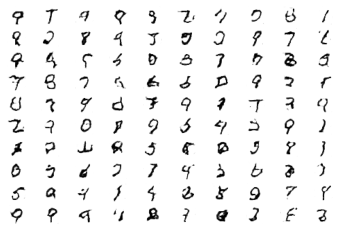

Saved generated_plot_007496.png and model_007496.h5
> Step 7500: d_loss1=0.277, d_loss2=0.307, g_loss=0.319
> Step 7600: d_loss1=0.276, d_loss2=0.271, g_loss=0.315
> Step 7700: d_loss1=0.300, d_loss2=0.290, g_loss=0.347
> Step 7800: d_loss1=0.304, d_loss2=0.275, g_loss=0.358
> Step 7900: d_loss1=0.271, d_loss2=0.354, g_loss=0.316
> Step 8000: d_loss1=0.279, d_loss2=0.324, g_loss=0.336
> Step 8100: d_loss1=0.318, d_loss2=0.308, g_loss=0.323
> Step 8200: d_loss1=0.255, d_loss2=0.283, g_loss=0.330
> Step 8300: d_loss1=0.332, d_loss2=0.312, g_loss=0.291
> Step 8400: d_loss1=0.262, d_loss2=0.293, g_loss=0.342


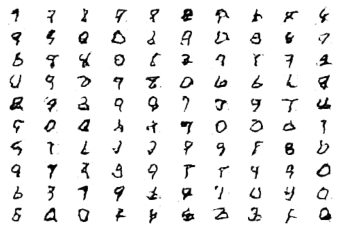

Saved generated_plot_008433.png and model_008433.h5
> Step 8500: d_loss1=0.218, d_loss2=0.363, g_loss=0.325
> Step 8600: d_loss1=0.281, d_loss2=0.323, g_loss=0.353
> Step 8700: d_loss1=0.252, d_loss2=0.295, g_loss=0.337
> Step 8800: d_loss1=0.265, d_loss2=0.331, g_loss=0.335
> Step 8900: d_loss1=0.298, d_loss2=0.323, g_loss=0.333
> Step 9000: d_loss1=0.285, d_loss2=0.327, g_loss=0.346
> Step 9100: d_loss1=0.344, d_loss2=0.312, g_loss=0.313
> Step 9200: d_loss1=0.277, d_loss2=0.335, g_loss=0.334
> Step 9300: d_loss1=0.315, d_loss2=0.324, g_loss=0.311


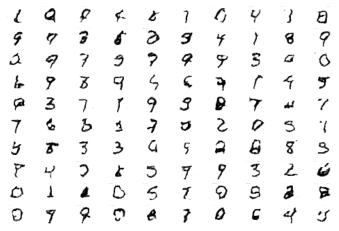

Saved generated_plot_009370.png and model_009370.h5
> Step 9400: d_loss1=0.321, d_loss2=0.323, g_loss=0.363
> Step 9500: d_loss1=0.288, d_loss2=0.331, g_loss=0.333
> Step 9600: d_loss1=0.285, d_loss2=0.336, g_loss=0.345
> Step 9700: d_loss1=0.334, d_loss2=0.326, g_loss=0.315
> Step 9800: d_loss1=0.310, d_loss2=0.331, g_loss=0.317
> Step 9900: d_loss1=0.312, d_loss2=0.320, g_loss=0.312
> Step 10000: d_loss1=0.301, d_loss2=0.296, g_loss=0.339
> Step 10100: d_loss1=0.285, d_loss2=0.277, g_loss=0.297
> Step 10200: d_loss1=0.274, d_loss2=0.314, g_loss=0.289
> Step 10300: d_loss1=0.326, d_loss2=0.331, g_loss=0.306


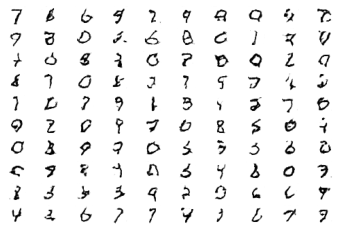

Saved generated_plot_010307.png and model_010307.h5
> Step 10400: d_loss1=0.304, d_loss2=0.301, g_loss=0.321
> Step 10500: d_loss1=0.296, d_loss2=0.294, g_loss=0.307
> Step 10600: d_loss1=0.292, d_loss2=0.317, g_loss=0.300
> Step 10700: d_loss1=0.302, d_loss2=0.303, g_loss=0.291
> Step 10800: d_loss1=0.288, d_loss2=0.288, g_loss=0.309
> Step 10900: d_loss1=0.303, d_loss2=0.293, g_loss=0.297
> Step 11000: d_loss1=0.303, d_loss2=0.320, g_loss=0.310
> Step 11100: d_loss1=0.325, d_loss2=0.286, g_loss=0.297
> Step 11200: d_loss1=0.279, d_loss2=0.309, g_loss=0.309


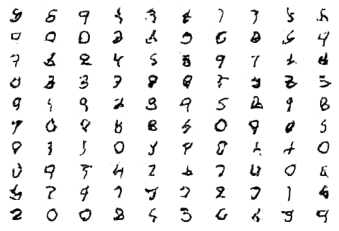

Saved generated_plot_011244.png and model_011244.h5
> Step 11300: d_loss1=0.278, d_loss2=0.295, g_loss=0.298
> Step 11400: d_loss1=0.292, d_loss2=0.286, g_loss=0.289
> Step 11500: d_loss1=0.300, d_loss2=0.314, g_loss=0.285
> Step 11600: d_loss1=0.282, d_loss2=0.295, g_loss=0.283
> Step 11700: d_loss1=0.283, d_loss2=0.314, g_loss=0.301
> Step 11800: d_loss1=0.281, d_loss2=0.304, g_loss=0.303
> Step 11900: d_loss1=0.308, d_loss2=0.296, g_loss=0.280
> Step 12000: d_loss1=0.299, d_loss2=0.293, g_loss=0.297
> Step 12100: d_loss1=0.289, d_loss2=0.301, g_loss=0.290


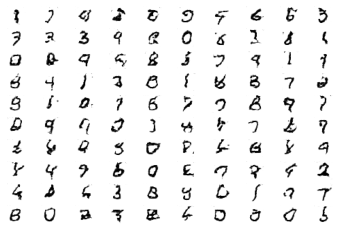

Saved generated_plot_012181.png and model_012181.h5
> Step 12200: d_loss1=0.280, d_loss2=0.299, g_loss=0.290
> Step 12300: d_loss1=0.296, d_loss2=0.283, g_loss=0.287
> Step 12400: d_loss1=0.287, d_loss2=0.288, g_loss=0.301
> Step 12500: d_loss1=0.294, d_loss2=0.290, g_loss=0.285
> Step 12600: d_loss1=0.282, d_loss2=0.296, g_loss=0.279
> Step 12700: d_loss1=0.296, d_loss2=0.302, g_loss=0.279
> Step 12800: d_loss1=0.274, d_loss2=0.300, g_loss=0.279
> Step 12900: d_loss1=0.287, d_loss2=0.289, g_loss=0.282
> Step 13000: d_loss1=0.271, d_loss2=0.289, g_loss=0.275
> Step 13100: d_loss1=0.266, d_loss2=0.269, g_loss=0.292


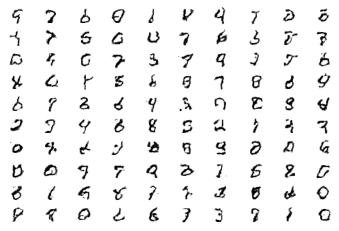

Saved generated_plot_013118.png and model_013118.h5
> Step 13200: d_loss1=0.276, d_loss2=0.288, g_loss=0.280
> Step 13300: d_loss1=0.279, d_loss2=0.278, g_loss=0.292
> Step 13400: d_loss1=0.280, d_loss2=0.271, g_loss=0.288
> Step 13500: d_loss1=0.264, d_loss2=0.291, g_loss=0.272
> Step 13600: d_loss1=0.272, d_loss2=0.282, g_loss=0.273
> Step 13700: d_loss1=0.271, d_loss2=0.287, g_loss=0.282
> Step 13800: d_loss1=0.286, d_loss2=0.289, g_loss=0.267
> Step 13900: d_loss1=0.286, d_loss2=0.291, g_loss=0.266
> Step 14000: d_loss1=0.274, d_loss2=0.294, g_loss=0.271


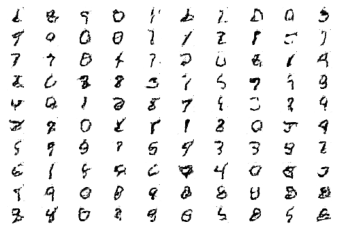

Saved generated_plot_014055.png and model_014055.h5
> Step 14100: d_loss1=0.257, d_loss2=0.291, g_loss=0.270
> Step 14200: d_loss1=0.271, d_loss2=0.293, g_loss=0.270
> Step 14300: d_loss1=0.271, d_loss2=0.302, g_loss=0.278
> Step 14400: d_loss1=0.270, d_loss2=0.293, g_loss=0.279
> Step 14500: d_loss1=0.267, d_loss2=0.303, g_loss=0.272
> Step 14600: d_loss1=0.293, d_loss2=0.283, g_loss=0.288
> Step 14700: d_loss1=0.281, d_loss2=0.284, g_loss=0.280
> Step 14800: d_loss1=0.268, d_loss2=0.285, g_loss=0.280
> Step 14900: d_loss1=0.288, d_loss2=0.293, g_loss=0.273


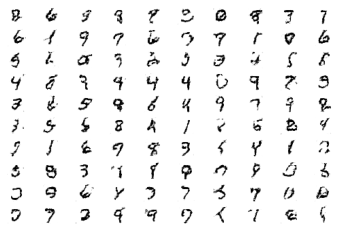

Saved generated_plot_014992.png and model_014992.h5
> Step 15000: d_loss1=0.276, d_loss2=0.278, g_loss=0.276
> Step 15100: d_loss1=0.301, d_loss2=0.276, g_loss=0.281
> Step 15200: d_loss1=0.291, d_loss2=0.290, g_loss=0.278
> Step 15300: d_loss1=0.279, d_loss2=0.291, g_loss=0.273
> Step 15400: d_loss1=0.279, d_loss2=0.290, g_loss=0.290
> Step 15500: d_loss1=0.284, d_loss2=0.285, g_loss=0.283
> Step 15600: d_loss1=0.267, d_loss2=0.290, g_loss=0.283
> Step 15700: d_loss1=0.283, d_loss2=0.301, g_loss=0.270
> Step 15800: d_loss1=0.279, d_loss2=0.273, g_loss=0.282
> Step 15900: d_loss1=0.272, d_loss2=0.290, g_loss=0.279


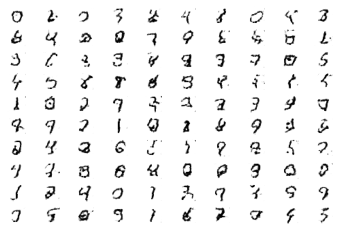

Saved generated_plot_015929.png and model_015929.h5
> Step 16000: d_loss1=0.265, d_loss2=0.288, g_loss=0.279
> Step 16100: d_loss1=0.265, d_loss2=0.287, g_loss=0.272
> Step 16200: d_loss1=0.283, d_loss2=0.290, g_loss=0.271
> Step 16300: d_loss1=0.275, d_loss2=0.280, g_loss=0.299
> Step 16400: d_loss1=0.276, d_loss2=0.279, g_loss=0.280
> Step 16500: d_loss1=0.277, d_loss2=0.290, g_loss=0.278
> Step 16600: d_loss1=0.278, d_loss2=0.275, g_loss=0.277
> Step 16700: d_loss1=0.271, d_loss2=0.280, g_loss=0.270
> Step 16800: d_loss1=0.288, d_loss2=0.287, g_loss=0.266


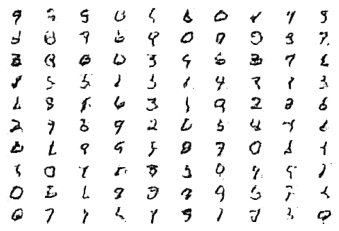

Saved generated_plot_016866.png and model_016866.h5
> Step 16900: d_loss1=0.295, d_loss2=0.285, g_loss=0.266
> Step 17000: d_loss1=0.267, d_loss2=0.271, g_loss=0.278
> Step 17100: d_loss1=0.272, d_loss2=0.273, g_loss=0.281
> Step 17200: d_loss1=0.276, d_loss2=0.282, g_loss=0.271
> Step 17300: d_loss1=0.278, d_loss2=0.289, g_loss=0.280
> Step 17400: d_loss1=0.278, d_loss2=0.287, g_loss=0.269
> Step 17500: d_loss1=0.263, d_loss2=0.267, g_loss=0.268
> Step 17600: d_loss1=0.272, d_loss2=0.280, g_loss=0.270
> Step 17700: d_loss1=0.282, d_loss2=0.285, g_loss=0.271
> Step 17800: d_loss1=0.269, d_loss2=0.279, g_loss=0.272


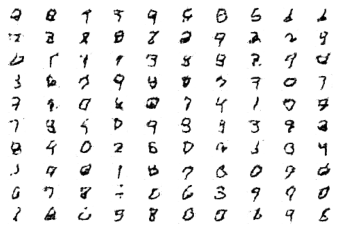

Saved generated_plot_017803.png and model_017803.h5
> Step 17900: d_loss1=0.274, d_loss2=0.275, g_loss=0.273
> Step 18000: d_loss1=0.273, d_loss2=0.278, g_loss=0.275
> Step 18100: d_loss1=0.253, d_loss2=0.280, g_loss=0.274
> Step 18200: d_loss1=0.270, d_loss2=0.279, g_loss=0.273
> Step 18300: d_loss1=0.269, d_loss2=0.276, g_loss=0.267
> Step 18400: d_loss1=0.270, d_loss2=0.268, g_loss=0.282
> Step 18500: d_loss1=0.272, d_loss2=0.272, g_loss=0.272
> Step 18600: d_loss1=0.277, d_loss2=0.271, g_loss=0.269
> Step 18700: d_loss1=0.273, d_loss2=0.271, g_loss=0.272
> Step 18740: d_loss1=0.277, d_loss2=0.277, g_loss=0.269


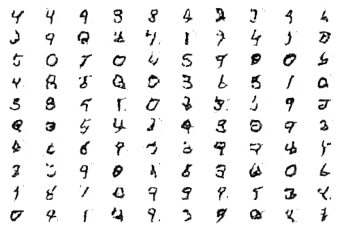

Saved generated_plot_018740.png and model_018740.h5
=> Saved plot_line_plot_loss.png


In [17]:
train(generator, discriminator, gan_model, dataset, latent_dim)